In [188]:
import json
import sys
from base64 import b64encode
from base64 import b64decode
from Crypto.Cipher import AES
from Crypto.Cipher import ChaCha20_Poly1305
from Crypto.Random import get_random_bytes
from time import process_time
import tracemalloc
import matplotlib.pyplot as plt
import numpy as np

In [189]:
fileSize = list()

In [190]:
init_encrypt_aes_memory = list()
init_encrypt_aes_memory_peak = list()
hashing_encrypt_aes_memory = list()
hashing_encrypt_aes_memory_peak = list()
encrypt_aes_memory = list()
encrypt_aes_memory_peak = list()
aes_encrypt_elapsed_time = list()

aes_decrypt_elapsed_time = list()
init_decrypt_aes_memory = list()
init_decrypt_aes_memory_peak = list()
hashing_decrypt_aes_memory = list()
hashing_decrypt_aes_memory_peak = list()
decrypt_aes_memory = list()
decrypt_aes_memory_peak = list()

In [191]:
init_encrypt_chacha_memory = list()
init_encrypt_chacha_memory_peak = list()
hashing_encrypt_chacha_memory = list()
hashing_encrypt_chacha_memory_peak = list()
encrypt_chacha_memory = list()
encrypt_chacha_memory_peak = list()
chacha_encrypt_elapsed_time = list()

chacha_decrypt_elapsed_time = list()
init_decrypt_chacha_memory = list()
init_decrypt_chacha_memory_peak = list()
hashing_decrypt_chacha_memory = list()
hashing_decrypt_chacha_memory_peak = list()
decrypt_chacha_memory = list()
decrypt_chacha_memory_peak = list()

In [192]:
init_encrypt_memory_prop = list()
init_encrypt_memory_peak_prop = list()
update_encrypt_memory_prop = list()
update_encrypt_memory_peak_prop = list()
encrypt_memory_prop = list()
encrypt_memory_peak_prop = list()
encrypt_time_prop = list()

init_decrypt_memory_prop = list()
init_decrypt_memory_peak_prop = list()
update_decrypt_memory_prop = list()
update_decrypt_memory_peak_prop = list()
decrypt_memory_prop = list()
decrypt_memory_peak_prop = list()
decrypt_time_prop = list()

In [193]:
for iter in range(4):
    print("\n\nArquivo "+str(iter+1))
    # Dados
    path = "dados/texto_"+str(iter+1)+".txt"
    with open (path, "r") as arquivoTexto:
        texto = arquivoTexto.read()
    fileSize.append(round(sys.getsizeof(texto)*0.001,2))
    print("Tamanho do arquivo txt: "+str(fileSize[iter])+"KB")
    # AES - Encriptação - Cifra de Bloco simétrica - CCM mode
    print("\tAES Criptografando")
    tracemalloc.start()
    aes_encrypt_time = process_time()
    header = b"header"

    # Carregando dados para criptografar
    data = texto.encode('UTF-8')
    # Chave 16-bytes AES-128
    key = get_random_bytes(16)

    # Inicializacao
    tracemalloc.clear_traces()
    cipher = AES.new(key, AES.MODE_CCM)
    init_encrypt_aes_memory_temp, init_encrypt_aes_memory_peak_temp = tracemalloc.get_traced_memory()

    # Hashing
    tracemalloc.clear_traces()
    cipher.update(header)
    hashing_encrypt_aes_memory_temp, hashing_encrypt_aes_memory_peak_temp = tracemalloc.get_traced_memory()

    # Criptografia
    tracemalloc.clear_traces()
    ciphertext, tag = cipher.encrypt_and_digest(data)
    encrypt_aes_memory_temp, encrypt_aes_memory_peak_temp = tracemalloc.get_traced_memory()

    # Calculando Tempo
    aes_encrypt_elapsed_time.append(process_time() - aes_encrypt_time)

    # Montando arquivo JSON com dados da criptografia
    json_k = [ 'nonce', 'header', 'ciphertext', 'tag' ]
    json_v = [ b64encode(x).decode('UTF-8') for x in (cipher.nonce, header, ciphertext, tag) ]
    result = json.dumps(dict(zip(json_k, json_v)))

    # Calculando estatisticas
    init_encrypt_aes_memory.append(init_encrypt_aes_memory_temp/10**3)
    init_encrypt_aes_memory_peak.append(init_encrypt_aes_memory_peak_temp/10**3)
    hashing_encrypt_aes_memory.append(hashing_encrypt_aes_memory_temp/10**3)
    hashing_encrypt_aes_memory_peak.append(hashing_encrypt_aes_memory_peak_temp/10**3)
    encrypt_aes_memory.append(encrypt_aes_memory_temp/10**3)
    encrypt_aes_memory_peak.append(encrypt_aes_memory_peak_temp/10**3)

    # Mostrando Resultados
    #print(result)
    print("\t\tUso de memoria na inicializacao: ", init_encrypt_aes_memory[iter], "KB. Pico: ", init_encrypt_aes_memory_peak[iter], "KB")
    print("\t\tUso de memoria no hashing: ", hashing_encrypt_aes_memory[iter], "KB. Pico: ", hashing_encrypt_aes_memory[iter], "KB")
    print("\t\tUso de memoria para criptografar: ", encrypt_aes_memory[iter], "KB. Pico: ", encrypt_aes_memory_peak[iter], "KB")
    print("\t\tAES Encriptação time: "+str(aes_encrypt_elapsed_time[iter])+"s")
    print("\tAES Encriptação - Complete\n")

    # AES - Descriptografia
    print("\tAES Descriptografando")
    try:
        aes_decrypt_time = process_time()

        # Montando mensagem para descriptografar
        b64 = json.loads(result)
        jv = {k:b64decode(b64[k]) for k in json_k}

        # Inicialiazacao
        tracemalloc.clear_traces()
        cipher = AES.new(key, AES.MODE_CCM, nonce=jv['nonce'])
        init_decrypt_aes_memory_temp, init_decrypt_aes_memory_peak_temp = tracemalloc.get_traced_memory()

        # Hashing
        tracemalloc.clear_traces()
        cipher.update(jv['header'])
        hashing_decrypt_aes_memory_temp, hashing_decrypt_aes_memory_peak_temp = tracemalloc.get_traced_memory()

        # Descriptografia
        tracemalloc.clear_traces()
        plaintext = cipher.decrypt_and_verify(jv['ciphertext'], jv['tag'])
        decrypt_aes_memory_temp, decrypt_aes_memory_peak_temp = tracemalloc.get_traced_memory()

        # Calculando Estatisticas
        aes_decrypt_elapsed_time.append(process_time() - aes_decrypt_time)
        init_decrypt_aes_memory.append(init_decrypt_aes_memory_temp/10**3)
        init_decrypt_aes_memory_peak.append(init_decrypt_aes_memory_peak_temp/10**3)
        hashing_decrypt_aes_memory.append(hashing_decrypt_aes_memory_temp/10**3)
        hashing_decrypt_aes_memory_peak.append(hashing_decrypt_aes_memory_peak_temp/10**3)
        decrypt_aes_memory.append(decrypt_aes_memory_temp/10**3)
        decrypt_aes_memory_peak.append(decrypt_aes_memory_peak_temp/10**3)

        # Mostrando Resultados
        #print("The message was: " + format(plaintext.decode("UTF-8")))
        print("\t\tUso de memoria na inicializacao: ", init_decrypt_aes_memory[iter], "KB. Pico: ", init_decrypt_aes_memory_peak[iter], "KB")
        print("\t\tUso de memoria no hashing: ", hashing_decrypt_aes_memory[iter], "KB. Pico: ", hashing_decrypt_aes_memory[iter], "KB")
        print("\t\tUso de memoria para descriptografar: ", decrypt_aes_memory[iter], "KB. Pico: ", decrypt_aes_memory_peak[iter], "KB")
        print("\t\tAES Descriptografia time: "+str(aes_decrypt_elapsed_time[iter])+"s")
        print("\tAES Descriptografia - Complete")
    except (ValueError, KeyError):
        print("\tIncorrect Descriptografia")

    # ChaCha20-Poly1305 - Encriptação - Cifra de Fluxo - com funcao MAC
    print("\n\tChaCha20-Poly1305 Criptografando")
    chacha_encrypt_time = process_time()
    header = b"header"

    # Carregando dados para criptografar
    plaintext = texto.encode('UTF-8')

    # Chave de 32 bytes
    key = get_random_bytes(32)

    # Inicializacao
    tracemalloc.clear_traces()
    cipher = ChaCha20_Poly1305.new(key=key)
    init_encrypt_chacha_memory_temp, init_encrypt_chacha_memory_peak_temp = tracemalloc.get_traced_memory()

    # Protecao para os dados associados
    tracemalloc.clear_traces()
    cipher.update(header)
    hashing_encrypt_chacha_memory_temp, hashing_encrypt_chacha_memory_peak_temp = tracemalloc.get_traced_memory()

    # Criptografia
    tracemalloc.clear_traces()
    ciphertext, tag = cipher.encrypt_and_digest(plaintext)
    encrypt_chacha_memory_temp, encrypt_chacha_memory_peak_temp = tracemalloc.get_traced_memory()

    # Calculando Tempo
    chacha_encrypt_elapsed_time.append(process_time() - chacha_encrypt_time)

    # Montando arquivo JSON com os dados
    jk = [ 'nonce', 'header', 'ciphertext', 'tag' ]
    jv = [ b64encode(x).decode('utf-8') for x in (cipher.nonce, header, ciphertext, tag) ]
    result = json.dumps(dict(zip(jk, jv)))

    # Calculando Estatisticas
    init_encrypt_chacha_memory.append(init_encrypt_chacha_memory_temp/10**3)
    init_encrypt_chacha_memory_peak.append(init_encrypt_chacha_memory_peak_temp/10**3)
    hashing_encrypt_chacha_memory.append(hashing_encrypt_chacha_memory_temp/10**3)
    hashing_encrypt_chacha_memory_peak.append(hashing_encrypt_chacha_memory_peak_temp/10**3)
    encrypt_chacha_memory.append(encrypt_chacha_memory_temp/10**3)
    encrypt_chacha_memory_peak.append(encrypt_chacha_memory_peak_temp/10**3)

    # Mostrando Resultados
    #print(result)
    print("\t\tUso de memoria na inicializacao: ", init_encrypt_chacha_memory[iter], "KB. Pico: ", init_encrypt_chacha_memory_peak[iter], "KB")
    print("\t\tUso de memoria no hashing: ", hashing_encrypt_chacha_memory[iter], "KB. Pico: ", hashing_encrypt_chacha_memory_peak[iter], "KB")
    print("\t\tUso de memoria para criptografar: ", encrypt_chacha_memory[iter], "KB. Pico: ", encrypt_chacha_memory_peak[iter], "KB")
    print("\t\tChaCha20-Poly1305 Encriptação time: "+str(chacha_encrypt_elapsed_time[iter])+"s")
    print("\tChaCha20-Poly1305 Encriptação - Complete\n")

    # ChaCha20-Poly1305 - Descriptografia
    print("\tChaCha20-Poly1305 Descriptografando")
    try:
        chacha_decrypt_time = process_time()

        # Montando mensagem para descriptografar
        b64 = json.loads(result)
        jk = [ 'nonce', 'header', 'ciphertext', 'tag' ]
        jv = {k:b64decode(b64[k]) for k in jk}

        # Inicialiazacao
        tracemalloc.clear_traces()
        cipher = ChaCha20_Poly1305.new(key=key, nonce=jv['nonce'])
        init_decrypt_chacha_memory_temp, init_decrypt_chacha_memory_peak_temp = tracemalloc.get_traced_memory()

        # Protecao para os dados associados
        tracemalloc.clear_traces()
        cipher.update(jv['header'])
        hashing_decrypt_chacha_memory_temp, hashing_decrypt_chacha_memory_peak_temp = tracemalloc.get_traced_memory()

        # Descriptografia
        tracemalloc.clear_traces()
        plaintext = cipher.decrypt_and_verify(jv['ciphertext'], jv['tag'])
        decrypt_chacha_memory_temp, decrypt_chacha_memory_peak_temp = tracemalloc.get_traced_memory()

        # Calculando Estatisticas
        chacha_decrypt_elapsed_time.append(process_time() - chacha_decrypt_time)
        init_decrypt_chacha_memory.append(init_decrypt_chacha_memory_temp/10**3)
        init_decrypt_chacha_memory_peak.append(init_decrypt_chacha_memory_peak_temp/10**3)
        hashing_decrypt_chacha_memory.append(hashing_decrypt_chacha_memory_temp/10**3)
        hashing_decrypt_chacha_memory_peak.append(hashing_decrypt_chacha_memory_peak_temp/10**3)
        decrypt_chacha_memory.append(decrypt_chacha_memory_temp/10**3)
        decrypt_chacha_memory_peak.append(decrypt_chacha_memory_peak_temp/10**3)

        # Mostrando Resultados
        #print("The message was: " + format(plaintext.decode("UTF-8")))
        print("\t\tUso de memoria na inicializacao: ", init_decrypt_chacha_memory[iter], "KB. Pico: ", init_decrypt_chacha_memory_peak[iter], "KB")
        print("\t\tUso de memoria no hashing: ", hashing_decrypt_chacha_memory[iter], "KB. Pico: ", hashing_decrypt_chacha_memory[iter], "KB")
        print("\t\tUso de memoria para descriptografar: ", decrypt_chacha_memory[iter], "KB. Pico: ", decrypt_chacha_memory_peak[iter], "KB")
        print("\t\tChaCha20-Poly1305 Descriptografia time: "+str(chacha_decrypt_elapsed_time[iter])+"s")
        print("\tChaCha20-Poly1305 Descriptografia - Complete\n")
    except (ValueError, KeyError):
        print("\tIncorrect Descriptografia")

    # Calculating proportions
    ########################################
    ############# Criptografia #############
    ########################################
    #### Inicializacao
    ######## Memory
    init_encrypt_memory_peak_prop.append(init_encrypt_aes_memory_peak[iter]/init_encrypt_chacha_memory_peak[iter])

    #### Update
    ######## Memory
    update_encrypt_memory_peak_prop.append(hashing_encrypt_aes_memory_peak[iter]/hashing_encrypt_chacha_memory_peak[iter])

    #### Criptografando
    ######## Memory
    encrypt_memory_peak_prop.append(encrypt_aes_memory_peak[iter]/encrypt_chacha_memory_peak[iter])
    ######## Time
    encrypt_time_prop.append(aes_encrypt_elapsed_time[iter]/chacha_encrypt_elapsed_time[iter])


    ########################################
    ########### Descriptografia ############
    ########################################
    ######## Memory
    init_decrypt_memory_peak_prop.append(init_decrypt_aes_memory_peak[iter]/init_decrypt_chacha_memory_peak[iter])

    #### Update
    ######## Memory
    update_decrypt_memory_peak_prop.append(hashing_decrypt_aes_memory_peak[iter]/hashing_decrypt_chacha_memory_peak[iter])

    #### Descriptografando
    ######## Memory
    decrypt_memory_peak_prop.append(decrypt_aes_memory_peak[iter]/decrypt_chacha_memory_peak[iter])
    ######## Time
    decrypt_time_prop.append(aes_decrypt_elapsed_time[iter]/chacha_decrypt_elapsed_time[iter])




Arquivo 1
Tamanho do arquivo txt: 6344.49KB
	AES Criptografando
		Uso de memoria na inicializacao:  1.106 KB. Pico:  2.759 KB
		Uso de memoria no hashing:  0.072 KB. Pico:  0.072 KB
		Uso de memoria para criptografar:  6349.539 KB. Pico:  12694.072 KB
		AES Encriptação time: 0.015625s
	AES Encriptação - Complete

	AES Descriptografando
		Uso de memoria na inicializacao:  1.062 KB. Pico:  2.731 KB
		Uso de memoria no hashing:  0.072 KB. Pico:  0.072 KB
		Uso de memoria para descriptografar:  6344.73 KB. Pico:  19033.74 KB
		AES Descriptografia time: 0.046875s
	AES Descriptografia - Complete

	ChaCha20-Poly1305 Criptografando
		Uso de memoria na inicializacao:  0.821 KB. Pico:  0.909 KB
		Uso de memoria no hashing:  0.0 KB. Pico:  0.056 KB
		Uso de memoria para criptografar:  6350.07 KB. Pico:  6350.138 KB
		ChaCha20-Poly1305 Encriptação time: 0.03125s
	ChaCha20-Poly1305 Encriptação - Complete

	ChaCha20-Poly1305 Descriptografando
		Uso de memoria na inicializacao:  0.776 KB. Pico:  0.

In [194]:
def autolabel(rects, ax, precision):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = round(rect.get_height(),precision)
        cond = "{:^,."+str(precision)+"f}"
        ax.annotate(cond.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 1),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

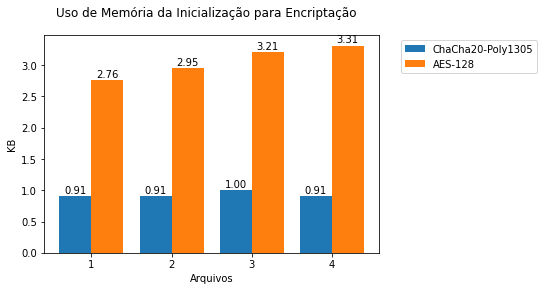

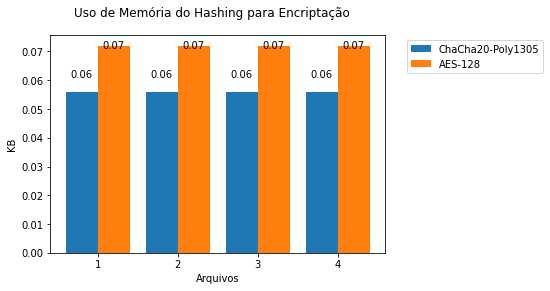

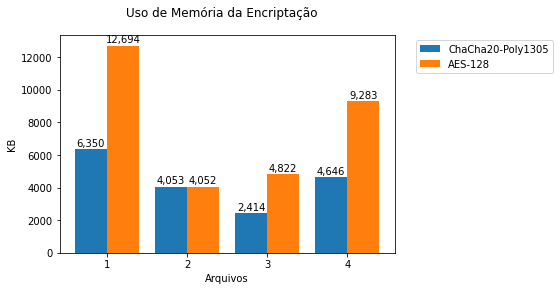

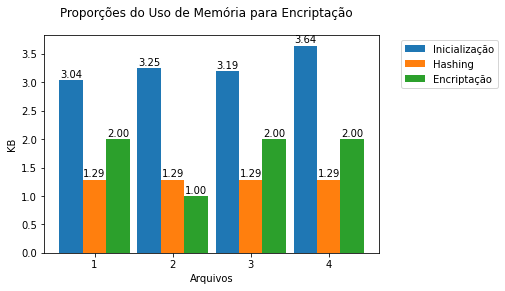

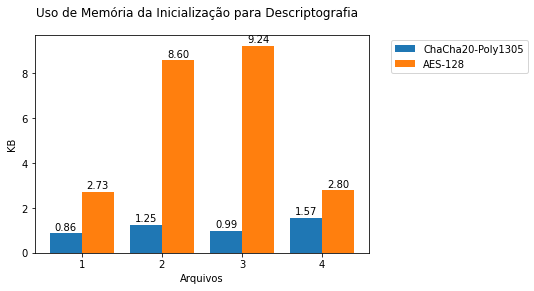

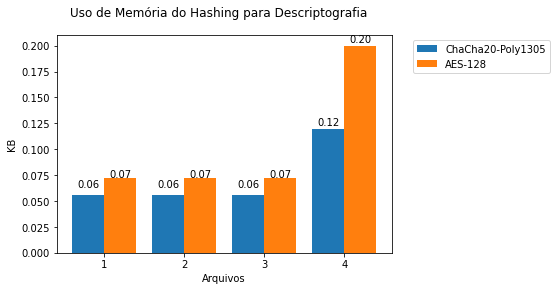

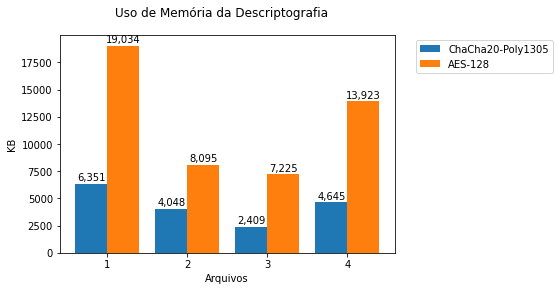

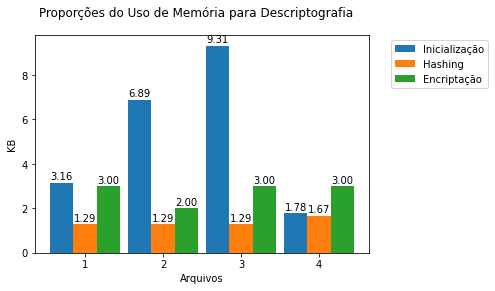

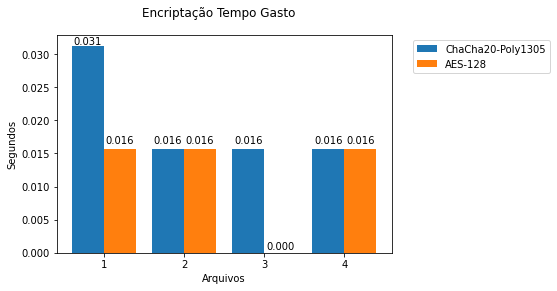

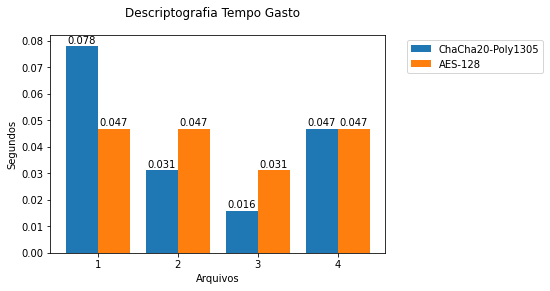

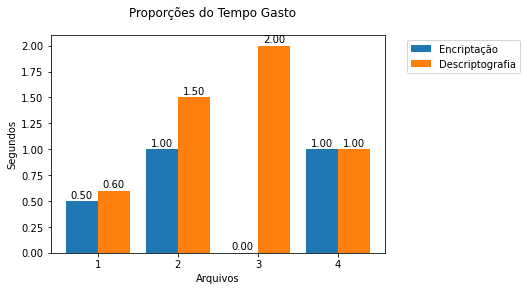

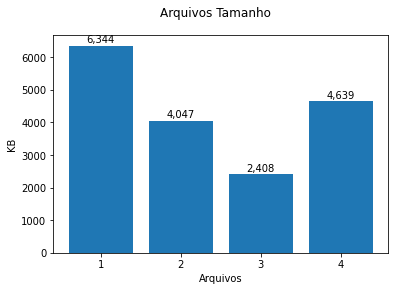

In [195]:
    arquivos = ["1","2","3","4"]
    x = np.arange(1,5,1)
    width = 0.4  # the width of the bars
    width2 = 0.3
    transparency = True

    fig, ax = plt.subplots()
    rect_1 = ax.bar(x-width/2, init_encrypt_chacha_memory_peak, width, label="ChaCha20-Poly1305")
    rect_2 = ax.bar(x+width/2, init_encrypt_aes_memory_peak, width, label="AES-128")
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.set_xlabel("Arquivos")
    ax.set_ylabel("KB")
    ax.set_xticks([1,2,3,4],minor=False)
    fig.suptitle('Uso de Memória da Inicialização para Encriptação')
    plt.savefig('figuras/memoria_inicializacao_encriptacao.png',dpi=300,transparent=transparency)
    autolabel(rect_1,ax,2)
    autolabel(rect_2,ax,2)
    plt.show()

    fig, ax = plt.subplots()
    rect_1 = ax.bar(x-width/2, hashing_encrypt_chacha_memory_peak, width, label="ChaCha20-Poly1305")
    rect_2 = ax.bar(x+width/2, hashing_encrypt_aes_memory_peak, width, label="AES-128")
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.set_xlabel("Arquivos")
    ax.set_ylabel("KB")
    ax.set_xticks([1,2,3,4],minor=False)
    fig.suptitle('Uso de Memória do Hashing para Encriptação')
    autolabel(rect_1,ax,2)
    autolabel(rect_2,ax,2)
    plt.savefig('figuras/memoria_hashing_encriptacao.png',dpi=300,transparent=transparency)
    plt.show()

    fig, ax = plt.subplots()
    rect_1 = ax.bar(x-width/2, encrypt_chacha_memory_peak, width, label="ChaCha20-Poly1305")
    rect_2 = ax.bar(x+width/2, encrypt_aes_memory_peak, width, label="AES-128")
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.set_xlabel("Arquivos")
    ax.set_ylabel("KB")
    ax.set_xticks([1,2,3,4],minor=False)
    fig.suptitle('Uso de Memória da Encriptação')
    autolabel(rect_1,ax,0)
    autolabel(rect_2,ax,0)
    plt.savefig('figuras/memoria_encriptacao.png',dpi=300,transparent=transparency)
    plt.show()

    fig, ax = plt.subplots()
    rect_1 = ax.bar(x-width2, init_encrypt_memory_peak_prop, width2, label="Inicialização")
    rect_2 = ax.bar(x, update_encrypt_memory_peak_prop, width2, label="Hashing")
    rect_3 = ax.bar(x+width2, encrypt_memory_peak_prop, width2, label="Encriptação")
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.set_xlabel("Arquivos")
    ax.set_ylabel("KB")
    ax.set_xticks([1,2,3,4],minor=False)
    fig.suptitle('Proporções do Uso de Memória para Encriptação')
    autolabel(rect_1,ax,2)
    autolabel(rect_2,ax,2)
    autolabel(rect_3,ax,2)
    plt.savefig('figuras/proporcoes_memoria_encriptacao.png',dpi=300,transparent=transparency)
    plt.show()

    fig, ax = plt.subplots()
    rect_1 = ax.bar(x-width/2, init_decrypt_chacha_memory_peak, width, label="ChaCha20-Poly1305")
    rect_2 = ax.bar(x+width/2, init_decrypt_aes_memory_peak, width, label="AES-128")
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.set_xlabel("Arquivos")
    ax.set_ylabel("KB")
    ax.set_xticks([1,2,3,4],minor=False)
    fig.suptitle('Uso de Memória da Inicialização para Descriptografia')
    autolabel(rect_1,ax,2)
    autolabel(rect_2,ax,2)
    plt.savefig('figuras/memoria_inicializacao_descriptografia.png',dpi=300,transparent=transparency)
    plt.show()

    fig, ax = plt.subplots()
    rect_1 = ax.bar(x-width/2, hashing_decrypt_chacha_memory_peak, width, label="ChaCha20-Poly1305")
    rect_2 = ax.bar(x+width/2, hashing_decrypt_aes_memory_peak, width, label="AES-128")
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.set_xlabel("Arquivos")
    ax.set_ylabel("KB")
    ax.set_xticks([1,2,3,4],minor=False)
    fig.suptitle('Uso de Memória do Hashing para Descriptografia')
    autolabel(rect_1,ax,2)
    autolabel(rect_2,ax,2)
    plt.savefig('figuras/memoria_hashing_descriptografia.png',dpi=300,transparent=transparency)
    plt.show()

    fig, ax = plt.subplots()
    rect_1 = ax.bar(x-width/2, decrypt_chacha_memory_peak, width, label="ChaCha20-Poly1305")
    rect_2 = ax.bar(x+width/2, decrypt_aes_memory_peak, width, label="AES-128")
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.set_xlabel("Arquivos")
    ax.set_ylabel("KB")
    ax.set_xticks([1,2,3,4],minor=False)
    fig.suptitle('Uso de Memória da Descriptografia')
    autolabel(rect_1,ax,0)
    autolabel(rect_2,ax,0)
    plt.savefig('figuras/memoria_descriptografia.png',dpi=300,transparent=transparency)
    plt.show()

    fig, ax = plt.subplots()
    rect_1 = ax.bar(x-width2, init_decrypt_memory_peak_prop, width2, label="Inicialização")
    rect_2 = ax.bar(x, update_decrypt_memory_peak_prop, width2, label="Hashing")
    rect_3 = ax.bar(x+width2, decrypt_memory_peak_prop, width2, label="Encriptação")
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.set_xlabel("Arquivos")
    ax.set_ylabel("KB")
    ax.set_xticks([1,2,3,4],minor=False)
    fig.suptitle('Proporções do Uso de Memória para Descriptografia')
    autolabel(rect_1,ax,2)
    autolabel(rect_2,ax,2)
    autolabel(rect_3,ax,2)
    plt.savefig('figuras/proporcoes_memoria_descriptografia.png',dpi=300,transparent=transparency)
    plt.show()

    fig, ax = plt.subplots()
    rect_1 = ax.bar(x-width/2, chacha_encrypt_elapsed_time, width, label="ChaCha20-Poly1305")
    rect_2 = ax.bar(x+width/2, aes_encrypt_elapsed_time, width, label="AES-128")
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.set_xlabel("Arquivos")
    ax.set_ylabel("Segundos")
    ax.set_xticks([1,2,3,4],minor=False)
    fig.suptitle('Encriptação Tempo Gasto')
    autolabel(rect_1,ax,3)
    autolabel(rect_2,ax,3)
    plt.savefig('figuras/encriptacao_tempo.png',dpi=300,transparent=transparency)
    plt.show()

    fig, ax = plt.subplots()
    rect_1 = ax.bar(x-width/2, chacha_decrypt_elapsed_time, width, label="ChaCha20-Poly1305")
    rect_2 = ax.bar(x+width/2, aes_decrypt_elapsed_time, width, label="AES-128")
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.set_xlabel("Arquivos")
    ax.set_ylabel("Segundos")
    ax.set_xticks([1,2,3,4],minor=False)
    fig.suptitle('Descriptografia Tempo Gasto')
    autolabel(rect_1,ax,3)
    autolabel(rect_2,ax,3)
    plt.savefig('figuras/descriptografia_tempo.png',dpi=300,transparent=transparency)
    plt.show()

    fig, ax = plt.subplots()
    rect_1 = ax.bar(x-width/2, encrypt_time_prop, width, label="Encriptação")
    rect_2 = ax.bar(x+width/2, decrypt_time_prop, width, label="Descriptografia")
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.set_xlabel("Arquivos")
    ax.set_ylabel("Segundos")
    ax.set_xticks([1,2,3,4],minor=False)
    fig.suptitle('Proporções do Tempo Gasto')
    autolabel(rect_1,ax,2)
    autolabel(rect_2,ax,2)
    plt.savefig('figuras/proporcoes_tempo.png',dpi=300,transparent=transparency)
    plt.show()

    fig, ax = plt.subplots()
    rect_1 = ax.bar(x, fileSize)
    ax.set_xlabel("Arquivos")
    ax.set_ylabel("KB")
    ax.set_xticks([1,2,3,4],minor=False)
    fig.suptitle('Arquivos Tamanho')
    autolabel(rect_1,ax,0)
    plt.savefig('figuras/tamanhos_arquivos.png',dpi=300,transparent=transparency)
    plt.show()